#Image Plant Classification with CNN

Given a dataset of 1350 plant disease photos divided in 5 classes (270 images each):
*   colpo_di_fuoco / fire_blight
*   flavescenza / flavescence
*   maculatura_bruna / brown spot
*   peronospora / downy mildew
*   ticchiolatura / scab

the aim of this project is to train the data (with different state of the art architectures and methods) and test the best models in order to be able (or at least try) to classify correctly the plant diseases.

##Creating the Dataset and assigning the labels

In [ ]:
import tensorflow as tf
import os
import keras
import numpy

In [ ]:
#importing the drive where the image dataset is
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.listdir('/content/drive/MyDrive/data')

['flavescenza',
 'maculatura_bruna',
 'colpo_di_fuoco',
 'ticchiolatura',
 'peronospora']

In [ ]:
#!pip install opencv-python
import cv2 #openCV
import imghdr #to check file extensions

In [ ]:
data_dir ='/content/drive/MyDrive/data'

In [ ]:
#image extentions/ formats allowed
image_ext = ['jpeg', 'jpg', 'bmp', 'png']
image_ext[0]

'jpeg'

In [ ]:
class_names = os.listdir(data_dir)
class_names 

['flavescenza',
 'maculatura_bruna',
 'colpo_di_fuoco',
 'ticchiolatura',
 'peronospora']

(1045, 1859, 3)


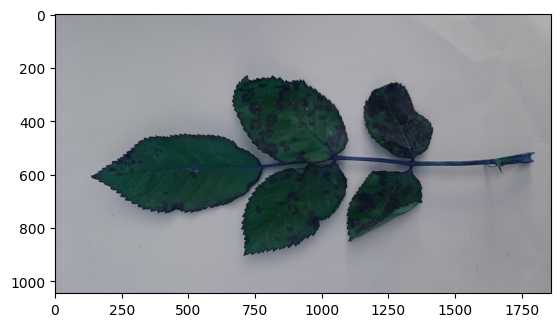

In [ ]:
#example
img = cv2.imread(os.path.join(data_dir, 'ticchiolatura', 'Ticchiolatura2.jpg'))
print(img.shape)

from matplotlib import pyplot as plt
plt.imshow(img)

<function matplotlib.pyplot.show(close=None, block=None)>

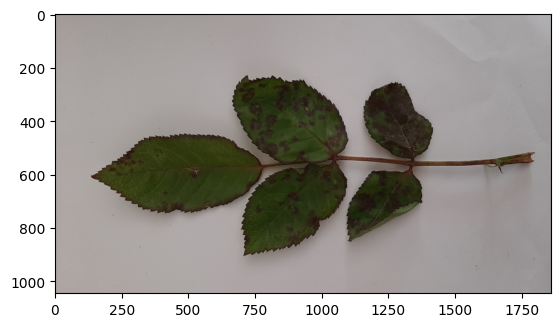

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

In [ ]:
#removed images not in the format desired
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)): 
        image_path = os.path.join(data_dir, image_class, image) #path of every image
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path) #return a string describing the image type
            if tip not in image_ext:
                print('Image not in ext list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [ ]:
import numpy as np
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data') #this build image dataset with batch_size=32,image_size=(256, 256) 
data #data pipeline

Found 1349 files belonging to 5 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#we need to convert data into a numpy iterator
data_iterator = data.as_numpy_iterator() #allowing us to access the data pipeline
data_iterator

In [ ]:
batch = data_iterator.next() #to loop into it
#images rapresented as numpy array
batch[0].shape #images

(32, 256, 256, 3)

In [ ]:
batch[1] #the numbers rapresent the labels

array([3, 4, 1, 1, 0, 2, 4, 1, 2, 2, 0, 0, 3, 1, 2, 0, 4, 0, 4, 3, 1, 1,
       4, 3, 1, 3, 2, 3, 2, 2, 3, 1], dtype=int32)

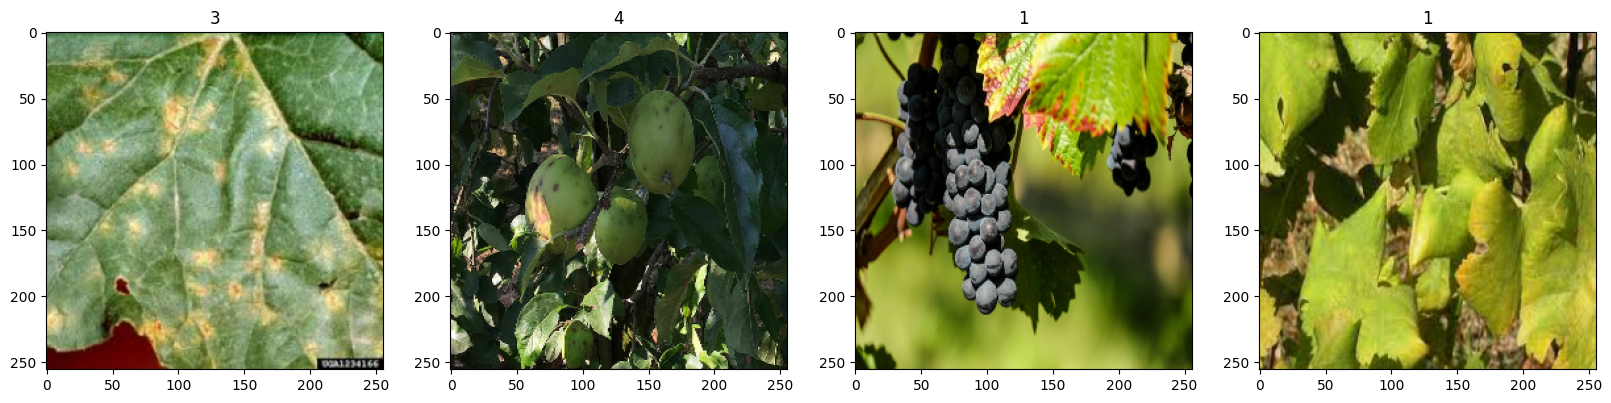

In [ ]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

0 = colpo_di_fuoco, 
1 = flavescenza, 
2 = maculatura_bruna, 
3 = peronospora, 
4 = ticchiolatura.

##Deep model Preprocessing

In [ ]:
batch[0].max() #you want value to be as small as possible

255.0

In [ ]:
#normalizing the data
scaled = batch[0]/ 255 #gives value between 0 and 1
print(scaled.min())
scaled.max()

0.0


1.0

In [ ]:
#we want to do it as we are loading the data
data = data.map(lambda x,y: (x/255, y)) #x is images and y is labels

In [ ]:
data.as_numpy_iterator().next()[0].max()

1.0

In [ ]:
len(data) #43 batches #1 batch is truncated

43

In [ ]:
#Splitting data in train, validation and test
train_size = int(len(data)*.7) #70% to training
val_size = int(len(data)*.2) #20% to validation
test_size = int (len(data)*.1) #10% to test

In [ ]:
print(train_size)
print(test_size)
print(val_size)

30
4
8


In [ ]:
#establishing train, val, test partionions
train = data.take(train_size) #take defines how much data we are gonna take in that partition
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
len(test)

4

##Building the network

In [ ]:
#Building Deep Learning Model
from keras import datasets, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
#LeNet
num_classes = len(class_names)
model = Sequential([
    layers.Input(shape=(256,256,3)),
    layers.Conv2D(6, kernel_size=(5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(16, kernel_size=(5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(num_classes, name='dense5', activation='softmax')
])

In [ ]:
#'adam' is a type of optimizer
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
#Sparse cross-entropy performs the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 252, 252, 6)       456       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 6)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 122, 122, 16)      2416      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 16)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 59536)             0         
                                                                 
 dense_8 (Dense)             (None, 120)              

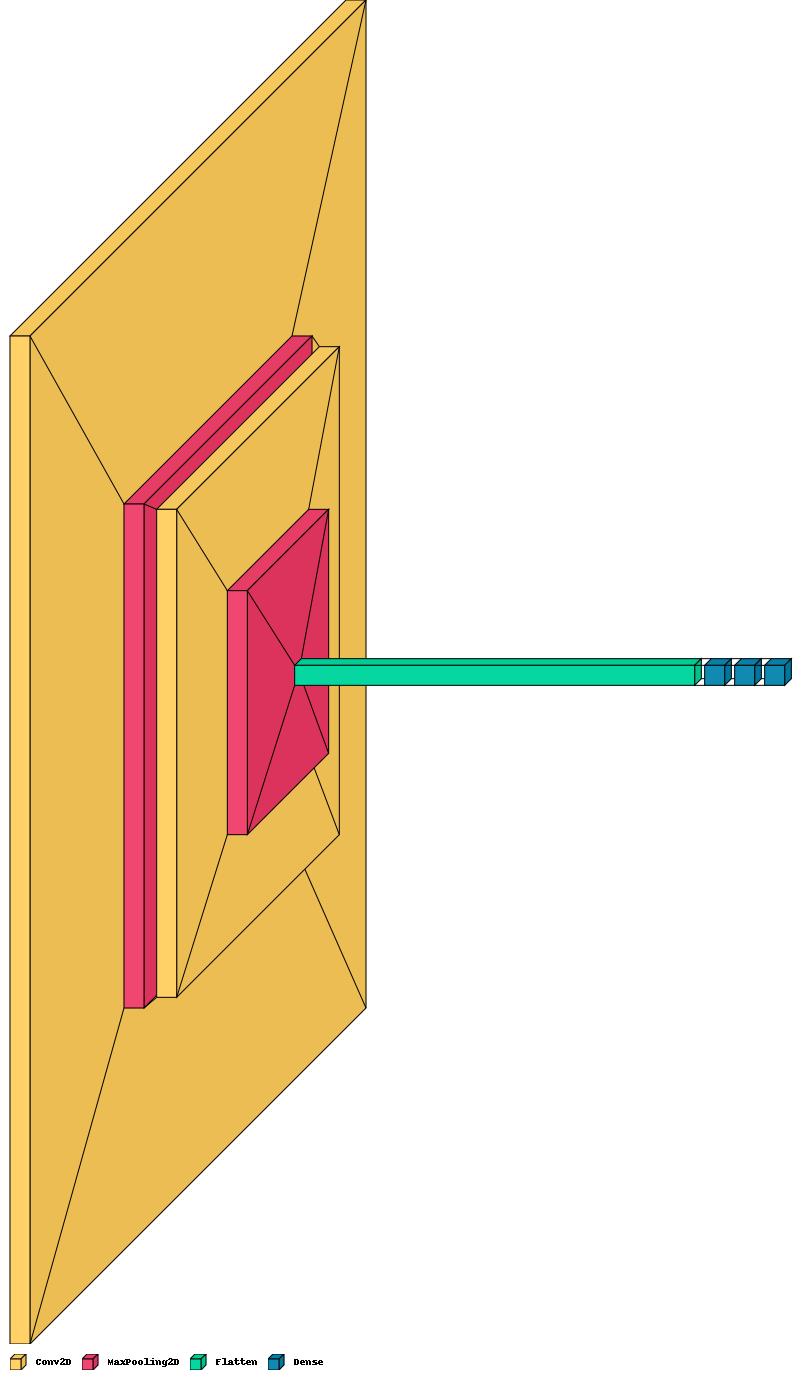

In [ ]:
#!pip install visualkeras
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [ ]:
#creating logs directory
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
30/30 [==============================] - 95s 3s/step - loss: 3.0869 - accuracy: 0.2156 - val_loss: 1.5725 - val_accuracy: 0.3086
Epoch 2/10
30/30 [==============================] - 90s 3s/step - loss: 1.4833 - accuracy: 0.3635 - val_loss: 1.3070 - val_accuracy: 0.4258
Epoch 3/10
30/30 [==============================] - 94s 3s/step - loss: 1.1740 - accuracy: 0.5646 - val_loss: 1.0668 - val_accuracy: 0.6328
Epoch 4/10
30/30 [==============================] - 94s 3s/step - loss: 0.8333 - accuracy: 0.7188 - val_loss: 0.9719 - val_accuracy: 0.6445
Epoch 5/10
30/30 [==============================] - 96s 3s/step - loss: 0.5483 - accuracy: 0.8323 - val_loss: 0.9284 - val_accuracy: 0.7188
Epoch 6/10
30/30 [==============================] - 93s 3s/step - loss: 0.3679 - accuracy: 0.8969 - val_loss: 0.6237 - val_accuracy: 0.8047
Epoch 7/10
30/30 [==============================] - 93s 3s/step - loss: 0.1619 - accuracy: 0.9552 - val_loss: 0.6595 - val_accuracy: 0.8047
Epoch 8/10
30/30 [==

In [ ]:
hist.history

{'loss': [3.0868656635284424,
  1.483276605606079,
  1.1739696264266968,
  0.83334881067276,
  0.5483390092849731,
  0.3679232895374298,
  0.16193953156471252,
  0.1156175509095192,
  0.09844492375850677,
  0.05118272081017494],
 'accuracy': [0.21562500298023224,
  0.3635416626930237,
  0.5645833611488342,
  0.71875,
  0.8322916626930237,
  0.8968750238418579,
  0.9552083611488342,
  0.971875011920929,
  0.9822916388511658,
  0.9937499761581421],
 'val_loss': [1.5724622011184692,
  1.3070399761199951,
  1.066834568977356,
  0.9719319343566895,
  0.9283918142318726,
  0.6237343549728394,
  0.6595491766929626,
  0.6001918911933899,
  0.7884306907653809,
  0.5665367245674133],
 'val_accuracy': [0.30859375,
  0.42578125,
  0.6328125,
  0.64453125,
  0.71875,
  0.8046875,
  0.8046875,
  0.83203125,
  0.82421875,
  0.8515625]}

In [ ]:
model.evaluate(test)

4/4 [==============================] - 14s 497ms/step - loss: 0.7463 - accuracy: 0.8281


[0.7463021874427795, 0.828125]

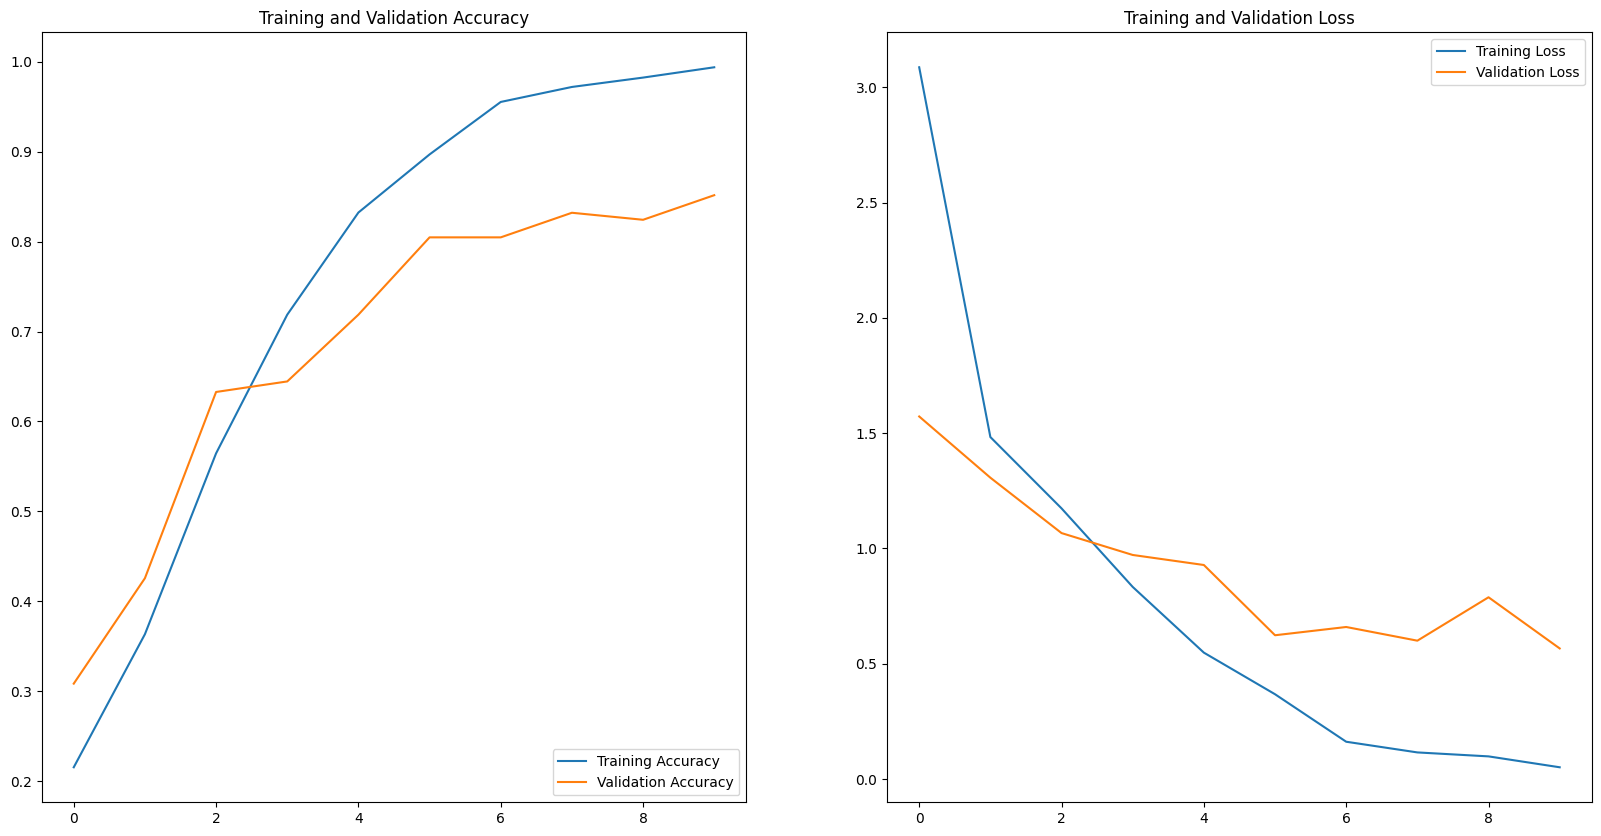

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

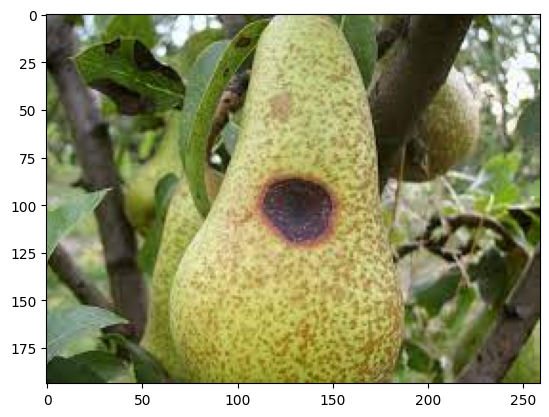

In [ ]:
#testing
class_names = ['colpo_di_fuoco',
 'flavescenza',
 'maculatura_bruna',
 'peronospora',
 'ticchiolatura']

img0 = cv2.imread('/content/drive/MyDrive/mac0.jpg')
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img0 = tf.image.resize(img0, (256,256)) #resize image before neural network
img_array = tf.keras.utils.img_to_array(img0)
img_array = tf.expand_dims(img_array, axis=0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(np.argmax(score))

print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)])
)

1/1 [==============================] - 0s 204ms/step
[[0. 0. 1. 0. 0.]]
2
This image most likely belongs to maculatura_bruna


In [ ]:
#to save the model
model.save(os.path.join('/content/drive/MyDrive/', 'image_plant_classifier.h5'))

In [ ]:
#to reload the saved model
saved_model =  keras.models.load_model(os.path.join('/content/drive/MyDrive/', 'image_plant_classifier.h5'))
saved_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 252, 252, 6)       456       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 6)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 122, 122, 16)      2416      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 16)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 59536)             0         
                                                                 
 dense_8 (Dense)             (None, 120)              

We develop a novel post-hoc visual explanation method called Score-CAM, which is the first gradient-free CAM-based (Class Activation Map) visualization method that achieves better visual performance (state-of-the-art). As said before this method is gradient-free unlike its predecessors GradCAM, GradCAM++ or Saliency.

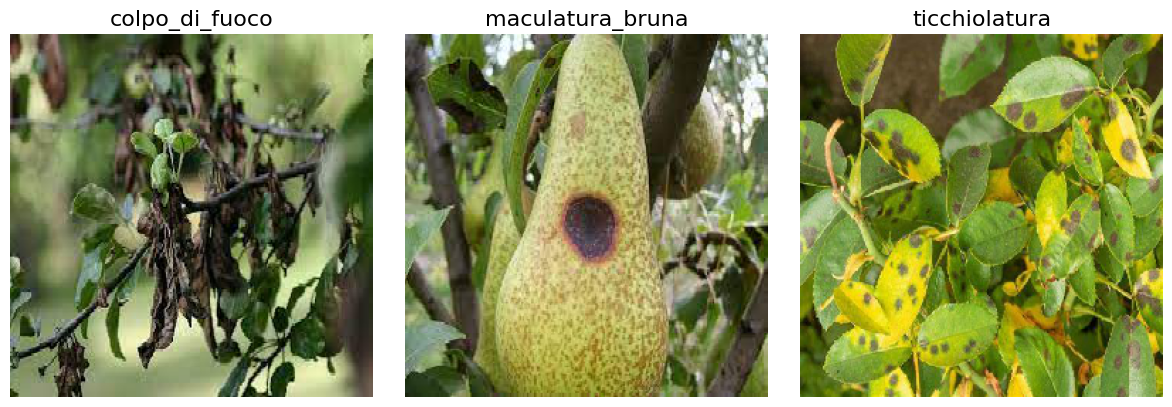

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['colpo_di_fuoco', 'maculatura_bruna', 'ticchiolatura']

# Load images and Convert them to a Numpy array
img1 = load_img('/content/drive/MyDrive/colpo0.jpg', target_size=(256, 256))
img2 = load_img('/content/drive/MyDrive/mac0.jpg', target_size=(256, 256))
img3 = load_img('/content/drive/MyDrive/ticch0.jpg', target_size=(256, 256))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
"""
When the softmax activation function is applied to the last layer of the model, it may obstruct generating the attention images,
so we should replace the function to a linear activation function. And then, we create Score instance that return target scores.
"""
#!pip install tf-keras-vis
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
replace2linear = ReplaceToLinear()
score = CategoricalScore(3)

2/2 [==============================] - 1s 332ms/step


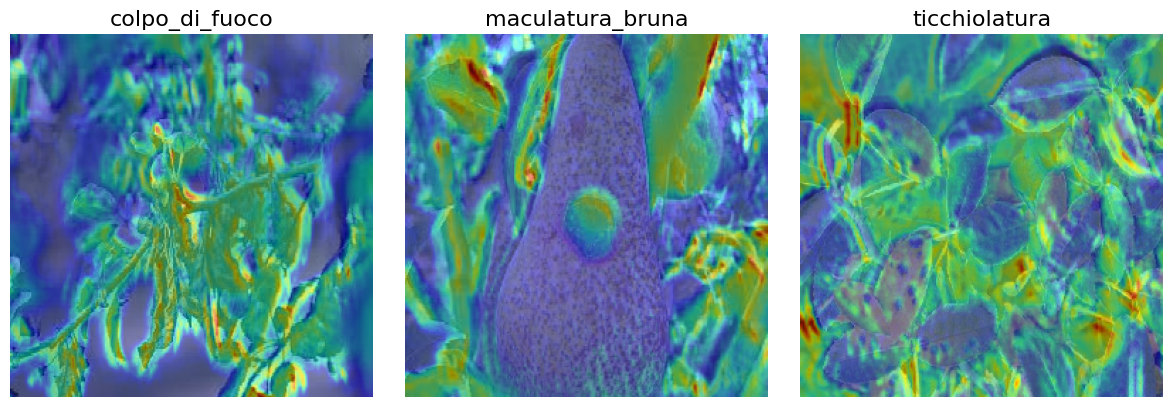

In [ ]:
from tf_keras_vis.scorecam import Scorecam
import matplotlib.cm as cm
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(saved_model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer='dense5')

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

##AlexNet implementation

In [ ]:
from keras import layers
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
from tensorflow.keras.regularizers import l2

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

In [ ]:
#AlexNet
Regularizer = l2(0.001)
model2 = keras.Sequential()
model2.add(data_augmentation)
model2.add(Conv2D(96, input_shape = (256, 256, 3),kernel_size=(11, 11),strides=(4,4), padding='valid', activation='relu', data_format='channels_last', 
                    activity_regularizer=Regularizer, kernel_regularizer=Regularizer)) #regularization to prevent overfitting
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
model2.add(layers.Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model2.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(4096, activation="relu"))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(units = 5, activation="softmax", activity_regularizer=Regularizer, kernel_regularizer=Regularizer)) #applied regularization to prevent overfitting

In [ ]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer='adam', 
              metrics=['accuracy'])
model2.build(input_shape=(None, 256, 256, 3))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_2 (Conv2D)           multiple                  34944     
                                                                 
 batch_normalization (BatchN  multiple                 384       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           multiple                  614656    
                                                                 
 batch_normalization_1 (Batc  multiple                

In [ ]:
#training
hist2 = model2.fit(train, epochs=10, validation_data=val, shuffle=True) #shuffle=True to damp overfitting

Epoch 1/10
30/30 [==============================] - 267s 9s/step - loss: 27.8597 - accuracy: 0.2792 - val_loss: 18.7042 - val_accuracy: 0.1758
Epoch 2/10
30/30 [==============================] - 268s 9s/step - loss: 18.7106 - accuracy: 0.2802 - val_loss: 13.4040 - val_accuracy: 0.1641
Epoch 3/10
30/30 [==============================] - 255s 8s/step - loss: 11.7362 - accuracy: 0.2552 - val_loss: 5.0154 - val_accuracy: 0.2461
Epoch 4/10
30/30 [==============================] - 255s 8s/step - loss: 8.8921 - accuracy: 0.2531 - val_loss: 4.2965 - val_accuracy: 0.1914
Epoch 5/10
30/30 [==============================] - 234s 8s/step - loss: 4.9616 - accuracy: 0.2885 - val_loss: 4.3238 - val_accuracy: 0.2344
Epoch 6/10
30/30 [==============================] - 250s 8s/step - loss: 3.3384 - accuracy: 0.2260 - val_loss: 4.3024 - val_accuracy: 0.1797
Epoch 7/10
30/30 [==============================] - 251s 8s/step - loss: 4.1867 - accuracy: 0.2156 - val_loss: 2.4856 - val_accuracy: 0.2109
Epoch 8/

Here we can already see that the model we are using here (AlexNet) is too complex.

To try **to prevent overfitting**, other than applying a shuffle parameter when we fit the model, I used **ridge regression**, a regularization technique. This technique update the general cost function by adding another term known as the **regularization term**:

Cost function = Loss function + Regularization term

Due to the addition of this regularization term, the values of weight matrices decrease because it assumes that a neural network with smaller weight matrices leads to simpler models. Therefore, it will also reduce overfitting to quite an extent.
In this model L2 regularization has been used. L2 regularization is also known as weight decay as it forces the weights to decay towards zero (but not exactly zero).
Unfortunately even by using regularization the model doesn't perform as well as the more simple LeNet model. 

In [ ]:
hist2.history

{'loss': [27.859678268432617,
  18.710609436035156,
  11.73615550994873,
  8.89213752746582,
  4.961599349975586,
  3.3384382724761963,
  4.186746120452881,
  2.8511266708374023,
  1.9120595455169678,
  1.779725432395935],
 'accuracy': [0.27916666865348816,
  0.2802083194255829,
  0.2552083432674408,
  0.25312501192092896,
  0.28854167461395264,
  0.22604165971279144,
  0.21562500298023224,
  0.19687500596046448,
  0.19687500596046448,
  0.19583334028720856],
 'val_loss': [18.7042236328125,
  13.404031753540039,
  5.015442848205566,
  4.296515464782715,
  4.323819160461426,
  4.302379131317139,
  2.4856209754943848,
  3.351369857788086,
  5.46835470199585,
  4.961417198181152],
 'val_accuracy': [0.17578125,
  0.1640625,
  0.24609375,
  0.19140625,
  0.234375,
  0.1796875,
  0.2109375,
  0.21875,
  0.1796875,
  0.15625]}

In [ ]:
model2.evaluate(test)

4/4 [==============================] - 17s 1s/step - loss: 4.9650 - accuracy: 0.1719


[4.964962959289551, 0.171875]

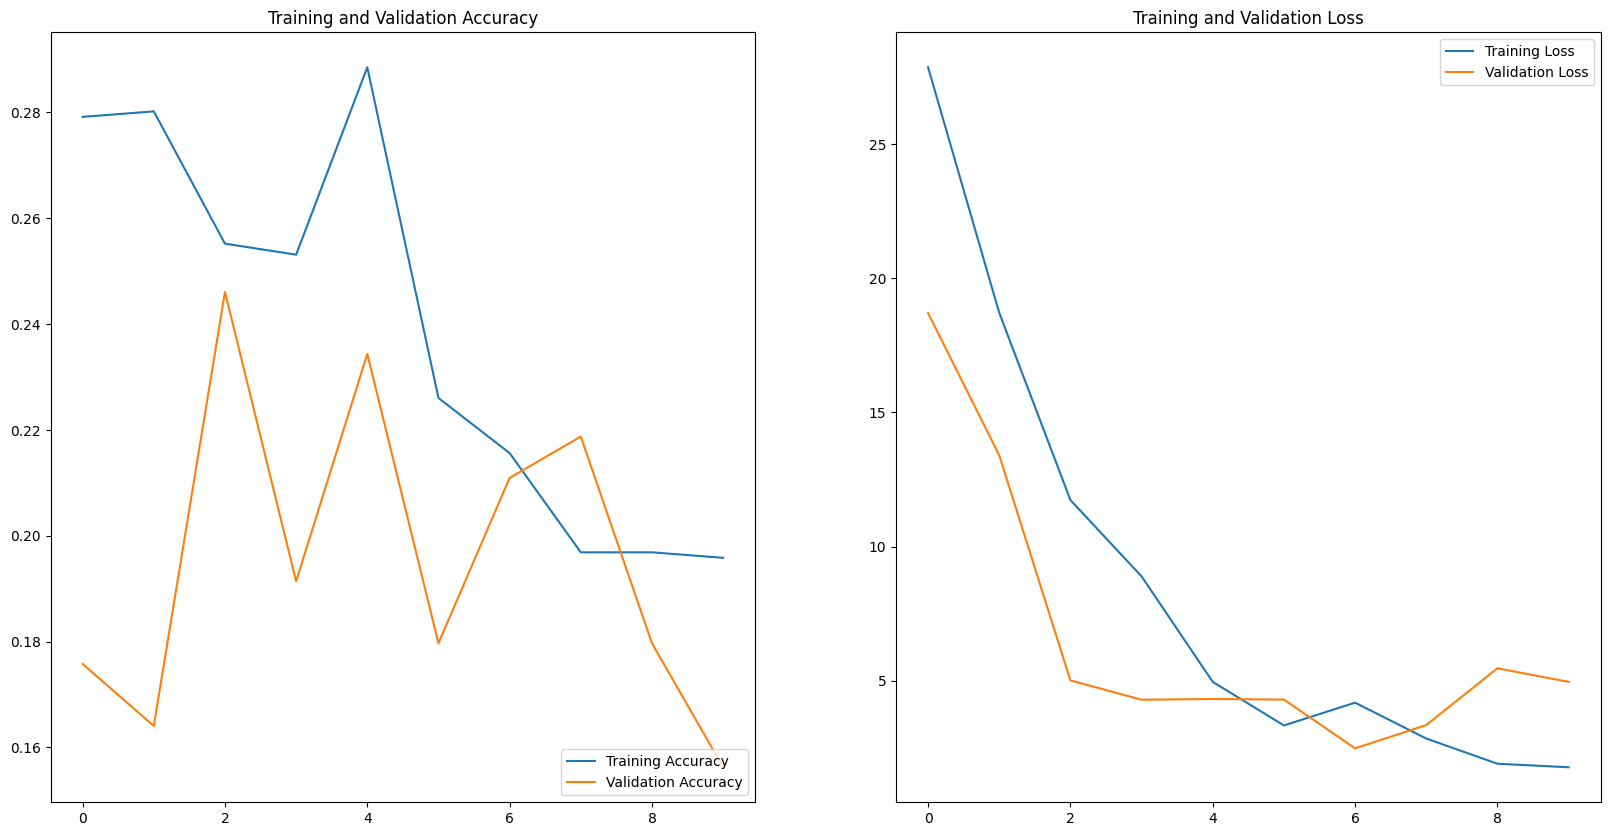

In [ ]:
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']

loss = hist2.history['loss']
val_loss = hist2.history['val_loss']


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Building a new model on top of features extracted

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#For layer in vgg.layers, layer.trainable=False to indicate that all the layers in the VGG16 model 
#are not to be trained again.
for layer in vgg.layers:
    layer.trainable = False
    
x = Flatten()(vgg.output)
prediction = Dense(5, activation='softmax')(x)
model3 = Model(inputs=vgg.input, outputs=prediction)
model3.summary()
model3.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                            

"\nmodel3 = Sequential()\nmodel3.add(base_model)\nmodel3.add(keras.layers.Flatten())\nmodel3.add(keras.layers.Dense(5, activation='softmax'))\nmodel3.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])\n\nmodel3.summary()\n"

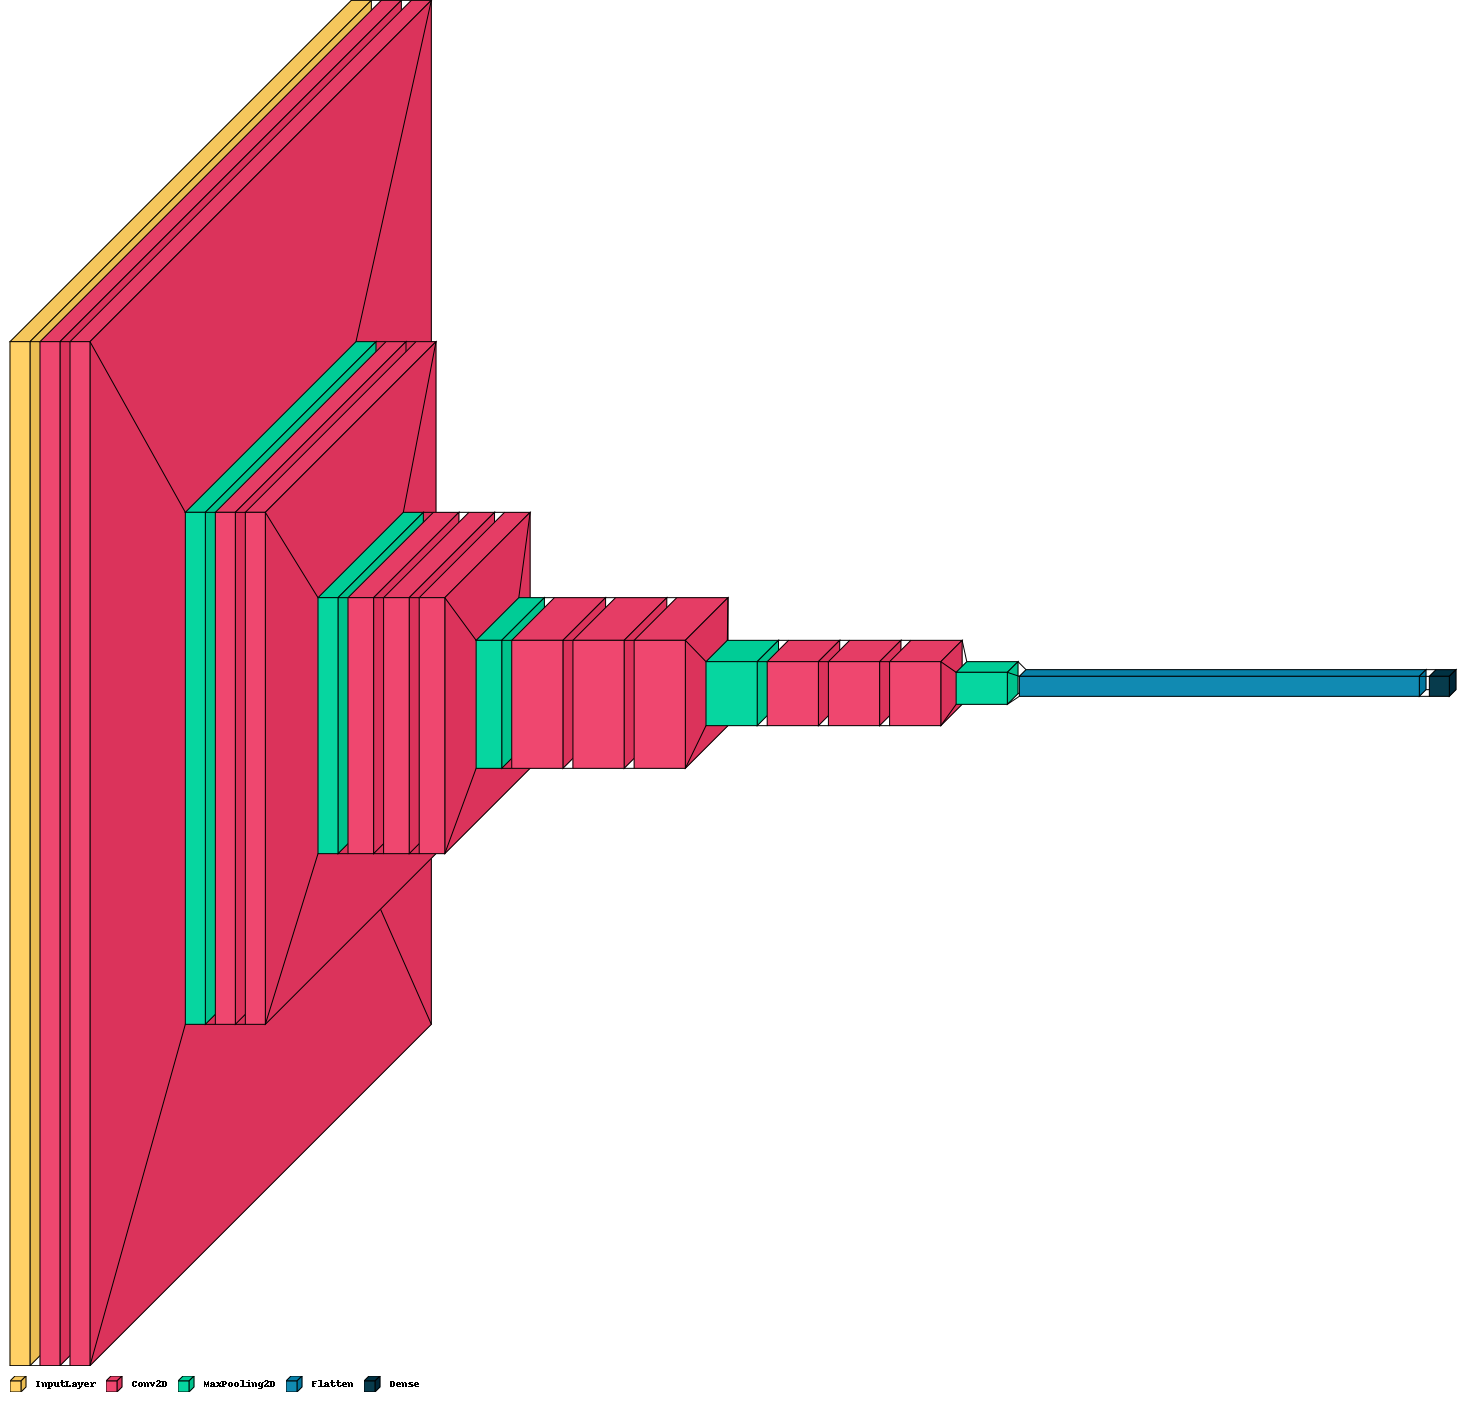

In [ ]:
visualkeras.layered_view(model3, legend=True)

In [ ]:
hist3 = model3.fit(train, epochs=10, validation_data=val)

Epoch 1/10
30/30 [==============================] - 646s 22s/step - loss: 1.5632 - accuracy: 0.4708 - val_loss: 0.9710 - val_accuracy: 0.6641
Epoch 2/10
30/30 [==============================] - 641s 21s/step - loss: 0.4703 - accuracy: 0.8375 - val_loss: 0.5245 - val_accuracy: 0.8086
Epoch 3/10
30/30 [==============================] - 639s 21s/step - loss: 0.2226 - accuracy: 0.9469 - val_loss: 0.3776 - val_accuracy: 0.8789
Epoch 4/10
30/30 [==============================] - 643s 22s/step - loss: 0.1453 - accuracy: 0.9750 - val_loss: 0.4628 - val_accuracy: 0.8672
Epoch 5/10
30/30 [==============================] - 642s 22s/step - loss: 0.1006 - accuracy: 0.9844 - val_loss: 0.4427 - val_accuracy: 0.8633
Epoch 6/10
30/30 [==============================] - 641s 21s/step - loss: 0.0850 - accuracy: 0.9854 - val_loss: 0.3242 - val_accuracy: 0.9180
Epoch 7/10
30/30 [==============================] - 642s 21s/step - loss: 0.0516 - accuracy: 0.9917 - val_loss: 0.3765 - val_accuracy: 0.8984
Epoch 

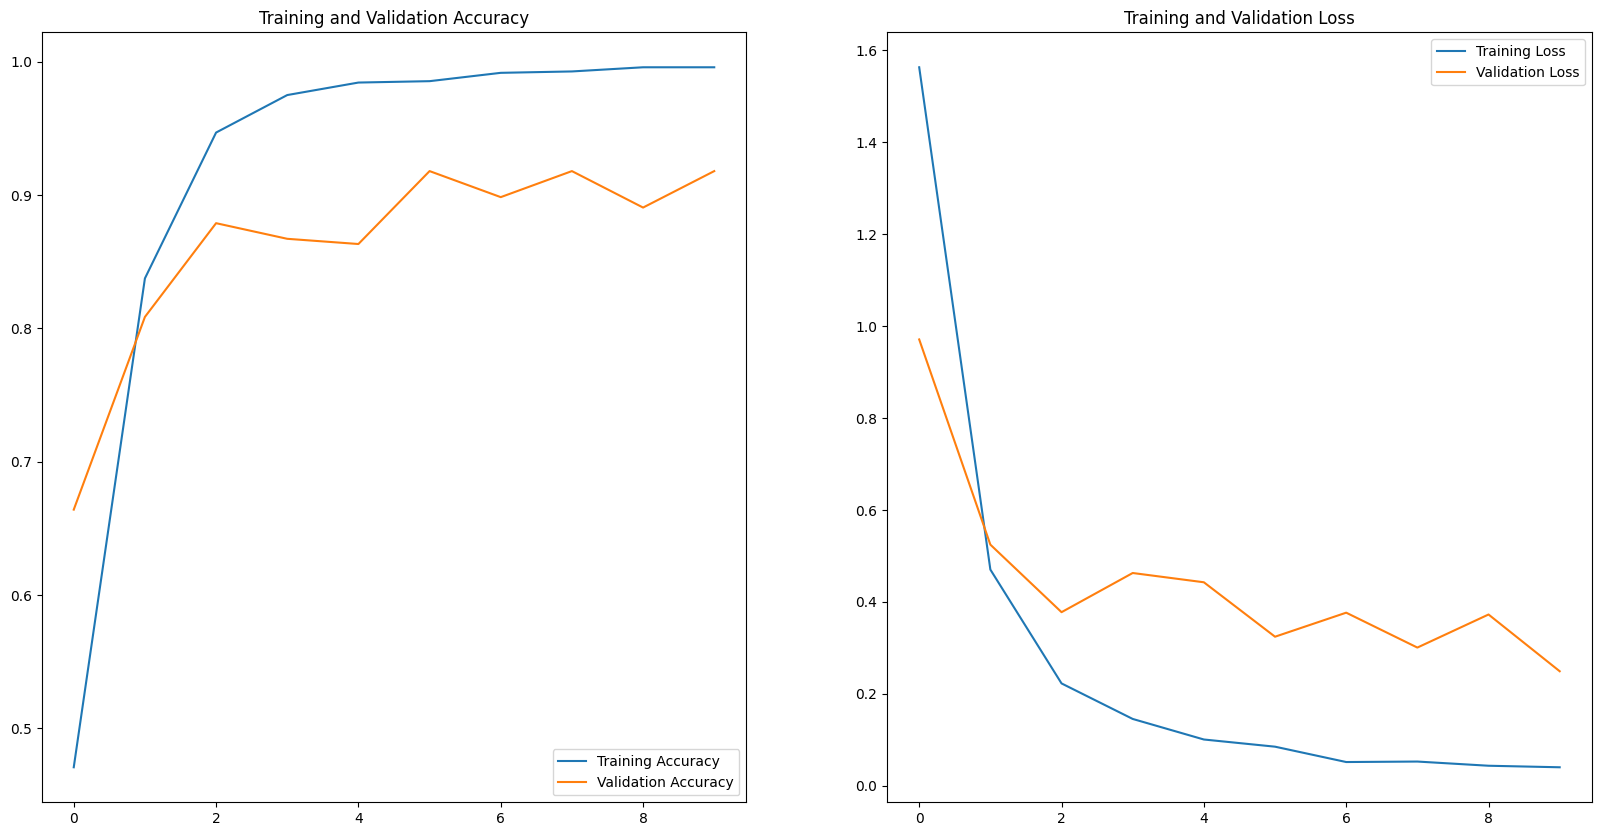

In [ ]:
acc = hist3.history['accuracy']
val_acc = hist3.history['val_accuracy']

loss = hist3.history['loss']
val_loss = hist3.history['val_loss']


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

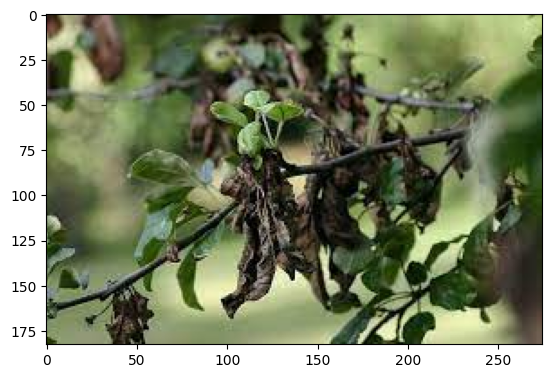

In [ ]:
#testing
class_names = ['colpo_di_fuoco',
 'flavescenza',
 'maculatura_bruna',
 'peronospora',
 'ticchiolatura']

img0 = cv2.imread('/content/drive/MyDrive/colpo0.jpg')
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img0 = tf.image.resize(img0, (256,256)) #resize image before neural network
img_array = tf.keras.utils.img_to_array(img0)
img_array = tf.expand_dims(img_array, axis=0) # Create a batch

predictions = model3.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(np.argmax(score))

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)

1/1 [==============================] - 1s 677ms/step
[[1. 0. 0. 0. 0.]]
0
This image most likely belongs to colpo_di_fuoco.


In [ ]:
#saving the model in google drive
model.save(os.path.join('/content/drive/MyDrive/', 'image_plant_classifier2.h5'))